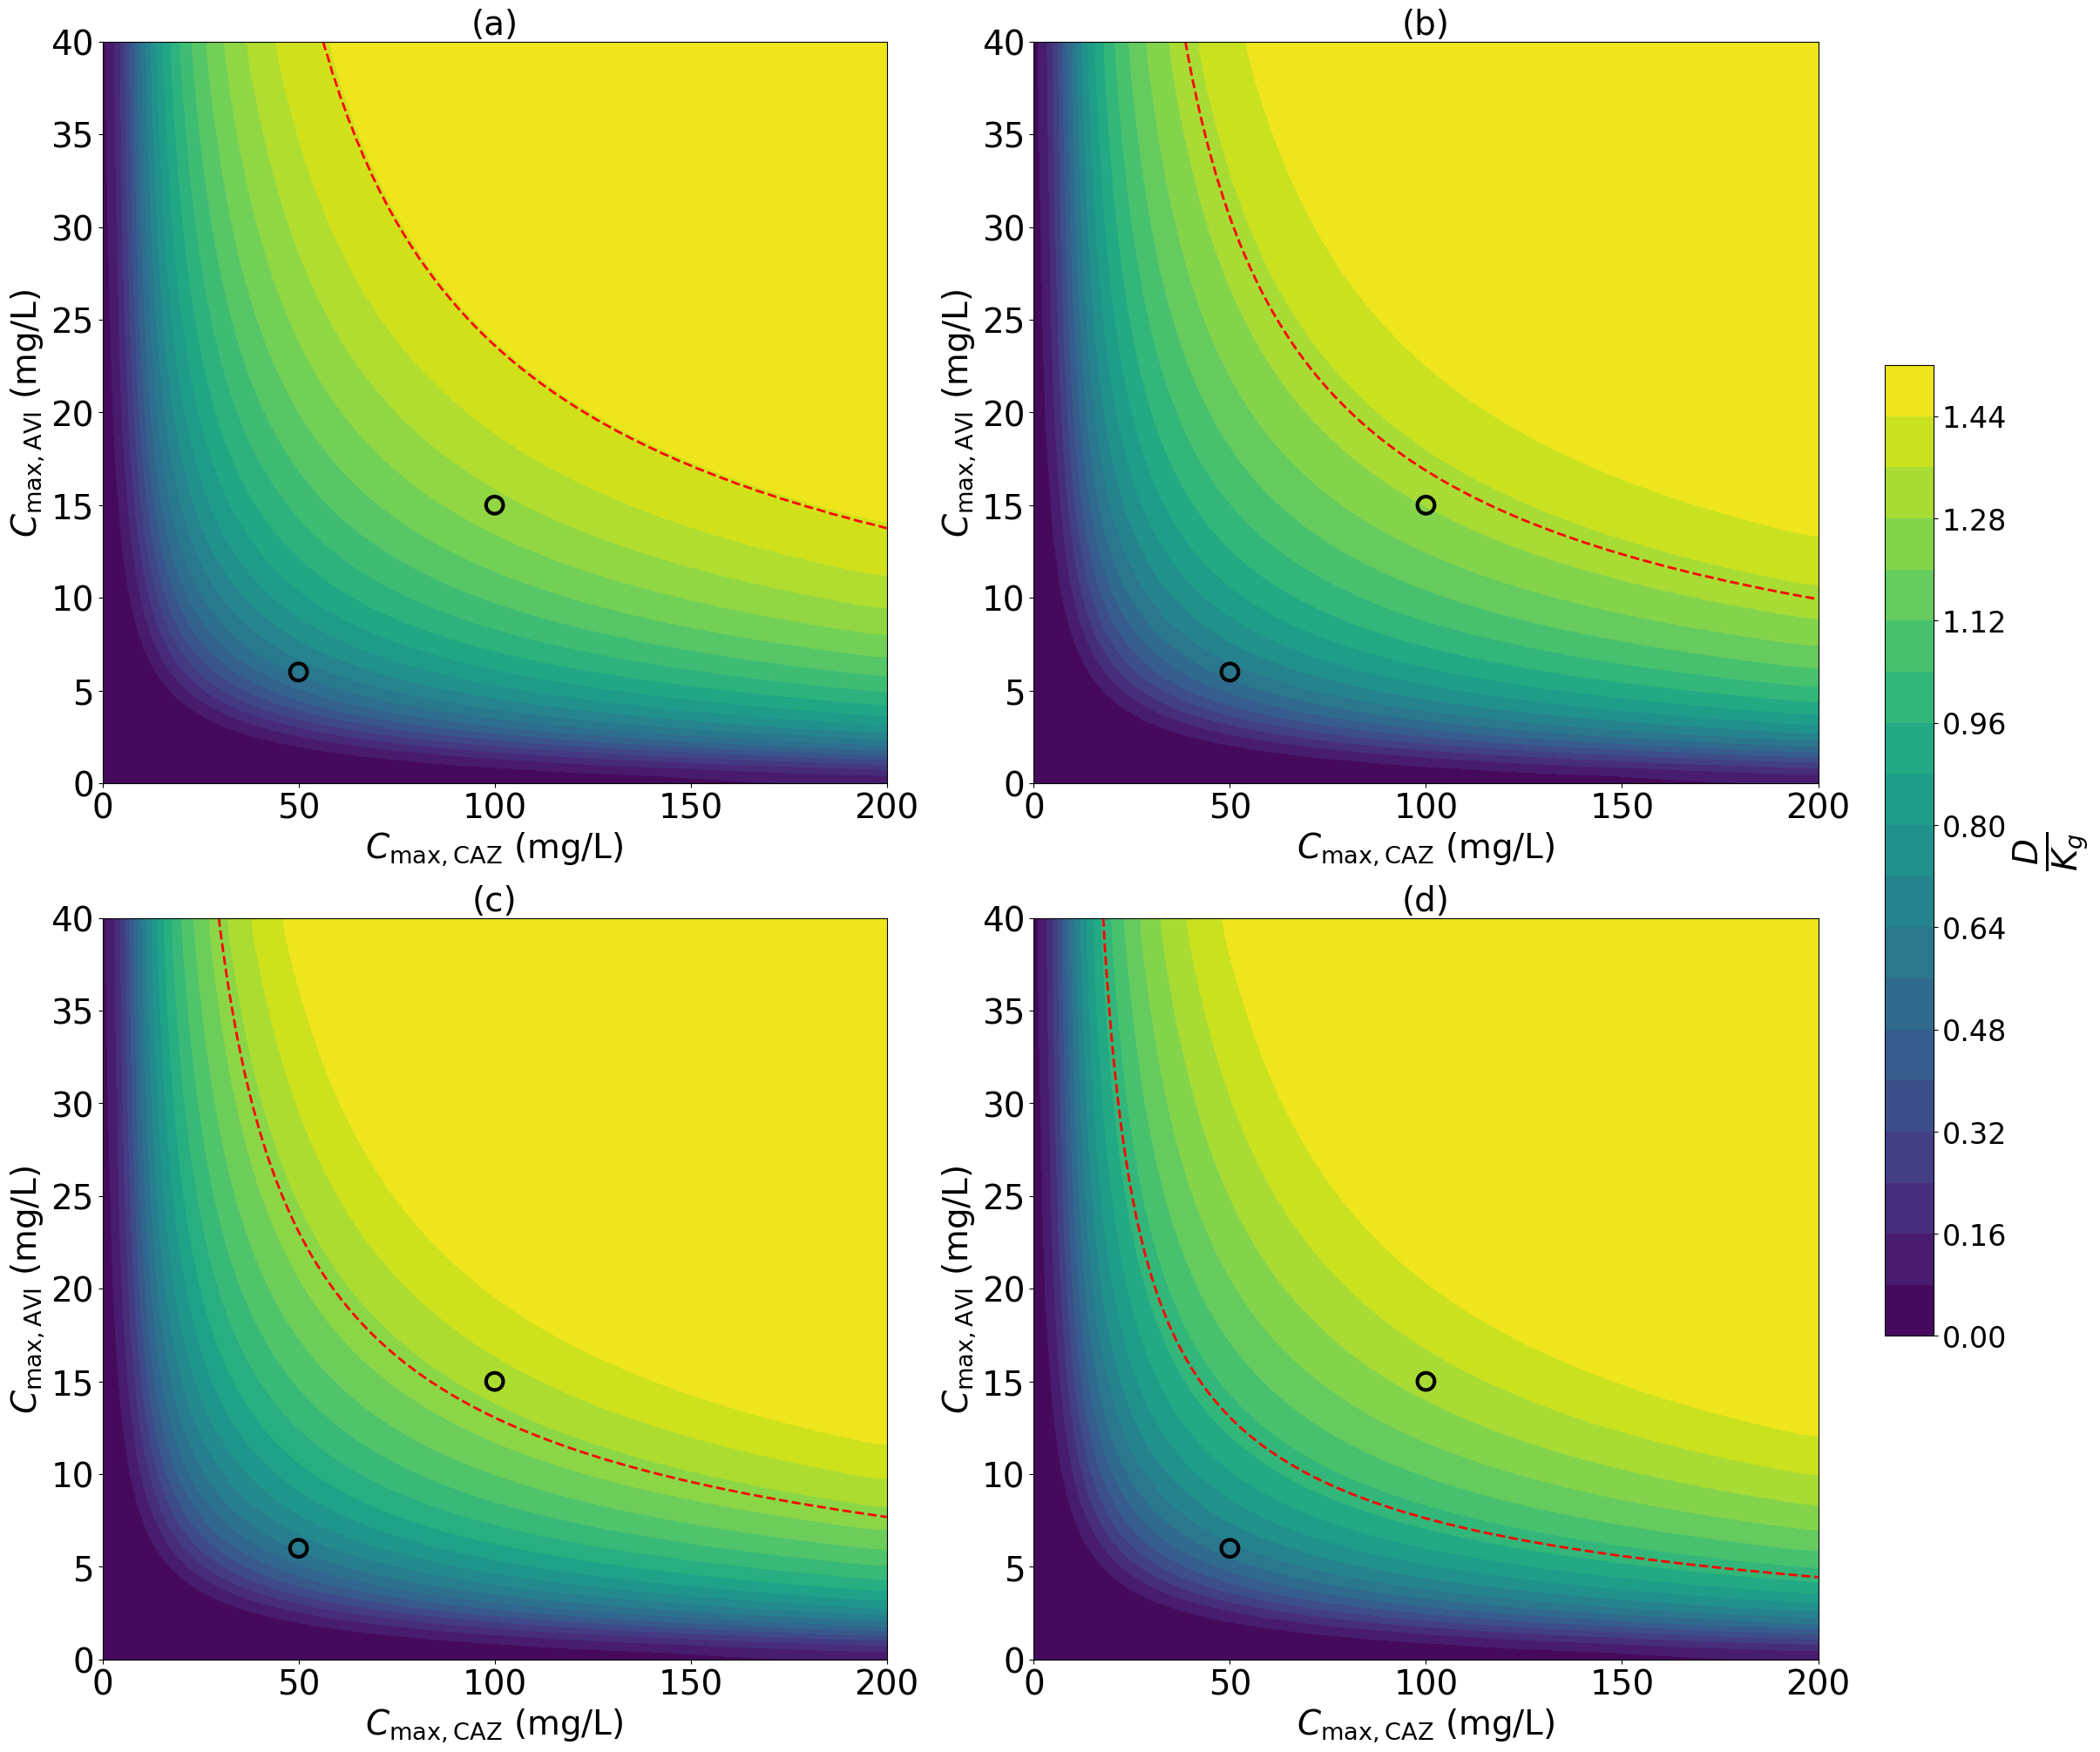

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter

# ─────────────────────────────────────────────────────────────────────────────
# Constants
H            = 12.7     # Hill coefficient
t_half       = 2.5      # Half-life (hours)
T_dosing     = 8.0      # Dosing interval (hours)
a            = 0.8458   # Updated parameter a
b            = 1.315    # Updated parameter b
c            = 0.9073
t_points     = 2        # Duration of zero-order release
D_target     = 1.0      # Threshold for D/Kg

# Updated pharmacodynamic function using the correct C(t) model
def C_t(t, Cmax):
    f0 = 2 ** (-(T_dosing - t_points) / t_half)
    if t <= t_points:
        return Cmax * (f0 * (1 - t / t_points) + t / t_points)
    else:
        return Cmax * 2 ** (-(t - t_points) / t_half)

def r_min_piecewise(t, Cmax_CAZ, Cmax_AVI):
    C_CAZ = C_t(t, Cmax_CAZ)
    C_AVI = C_t(t, Cmax_AVI)
    log10_C50 = a / (b - (c ** C_AVI))
    C50 = 10 ** log10_C50
    num = C_CAZ ** H
    den = num + C50 ** H
    return num / den

# ─────────────────────────────────────────────────────────────────────────────
# Grid of concentrations
Caz_vals = np.linspace(0, 200, 100)
Avi_vals = np.linspace(0, 40,  100)
X, Y = np.meshgrid(Caz_vals, Avi_vals)

# Dosing points
dosing_pts = [(100, 15), (50, 6)]

# Ratios and panel labels
K_values     = [1.01, 1.1, 1.2, 1.5]
panel_labels = ['(a)',   '(b)',  '(c)',  '(d)']

# ─────────────────────────────────────────────────────────────────────────────
# Create 2×2 contour subplots
fig, axes = plt.subplots(2, 2, figsize=(24, 20), constrained_layout=True)

for ax, K, lbl in zip(axes.ravel(), K_values, panel_labels):
    # Compute raw D/Kg surface
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            int1, _ = quad(lambda t: r_min_piecewise(t, X[i,j], Y[i,j]), 0, T_dosing)
            avg_rmin = int1 / T_dosing
            Z[i,j] = K * avg_rmin

    # Smooth for filled contour
    Z_smooth = gaussian_filter(Z, sigma=2)

    # Filled contour
    cf = ax.contourf(X, Y, Z_smooth, levels=20, cmap='viridis')

    # Threshold contour from raw Z
    ax.contour(X, Y, Z, levels=[D_target], colors='red', linestyles='--', linewidths=2)

    # Dosing points
    for C_CAZ, C_AVI in dosing_pts:
        ax.scatter(C_CAZ, C_AVI, s=200, facecolors='none', edgecolors='black', linewidths=3)

    # Labels
    ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}$ (mg/L)', fontsize=28)
    ax.set_ylabel(r'$C_{\mathrm{max,AVI}}$ (mg/L)', fontsize=28)
    ax.set_title(lbl, fontsize=28)
    ax.tick_params(axis='both', labelsize=28)

# Shared colorbar
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label(r'$\frac{D}{K_g}$', fontsize=40)
cbar.ax.tick_params(labelsize=24)

plt.show()



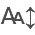

In [23]:
import numpy as np
from scipy.integrate import quad
import pandas as pd
from itables import show, init_notebook_mode

# ──────────────────────────── 0. INITIALISE ────────────────────────────
init_notebook_mode(all_interactive=True)

H        = 12.7      # Hill coefficient
t_half   = 2.5       # Half‑life (h)
T_period = 8.0       # Dosing interval, T_period in the equation (h)
T0       = 2.0       # Zero‑/slow‑release window (h)

# Updated empirical parameters for C50 model
a = 0.8458
b = 1.315
c = 0.907

# ───────────────────────── 1. CONCENTRATION MODEL ──────────────────────
def conc_profile(t, C_max):
    """
    Piece‑wise concentration profile
    C(t) = C_max * [
        2^{-((T_period - T0)/t_half)} * (1 - t/T0) + t/T0,        0 ≤ t ≤ T0
        2^{-((t - T0)/t_half)},                                   T0 < t ≤ T_period
    ]
    """
    if t <= T0:
        factor0 = 2 ** (-(T_period - T0) / t_half)
        return C_max * (factor0 * (1 - t / T0) + t / T0)
    return C_max * 2 ** (-(t - T0) / t_half)

# ───────────────────────── 2. r_min FUNCTION ───────────────────────────
def r_min(t, C_max_CAZ, C_max_AVI):
    C_CAZ_t = conc_profile(t, C_max_CAZ)
    C_AVI_t = conc_profile(t, C_max_AVI)

    # log10(C50) = a / (b − c^C_AVI)
    log10_C50 = a / (b - c ** C_AVI_t)
    C50       = 10 ** log10_C50

    num = C_CAZ_t ** H
    return num / (num + C50 ** H)

# ───────────────────────── 3. SCENARIO GRID ────────────────────────────
combinations = [(100, 15), (50, 6)]
K_vals       = [1.01, 1.1, 1.2, 1.5]

rows = []
for K in K_vals:
    for C_CAZ, C_AVI in combinations:
        integral, _ = quad(lambda t: r_min(t, C_CAZ, C_AVI), 0, T_period, limit=100)
        avg_rmin = integral / T_period
        rows.append({
            "Kmax/Kg":              K,
            "Cmax CAZ (mg/L)":      C_CAZ,
            "Cmax AVI (mg/L)":      C_AVI,
            "Avg r_min (h⁻¹)":      round(avg_rmin, 4),
            "D/Kg":                 round(K * avg_rmin, 4)
        })

df = pd.DataFrame(rows)
show(df)


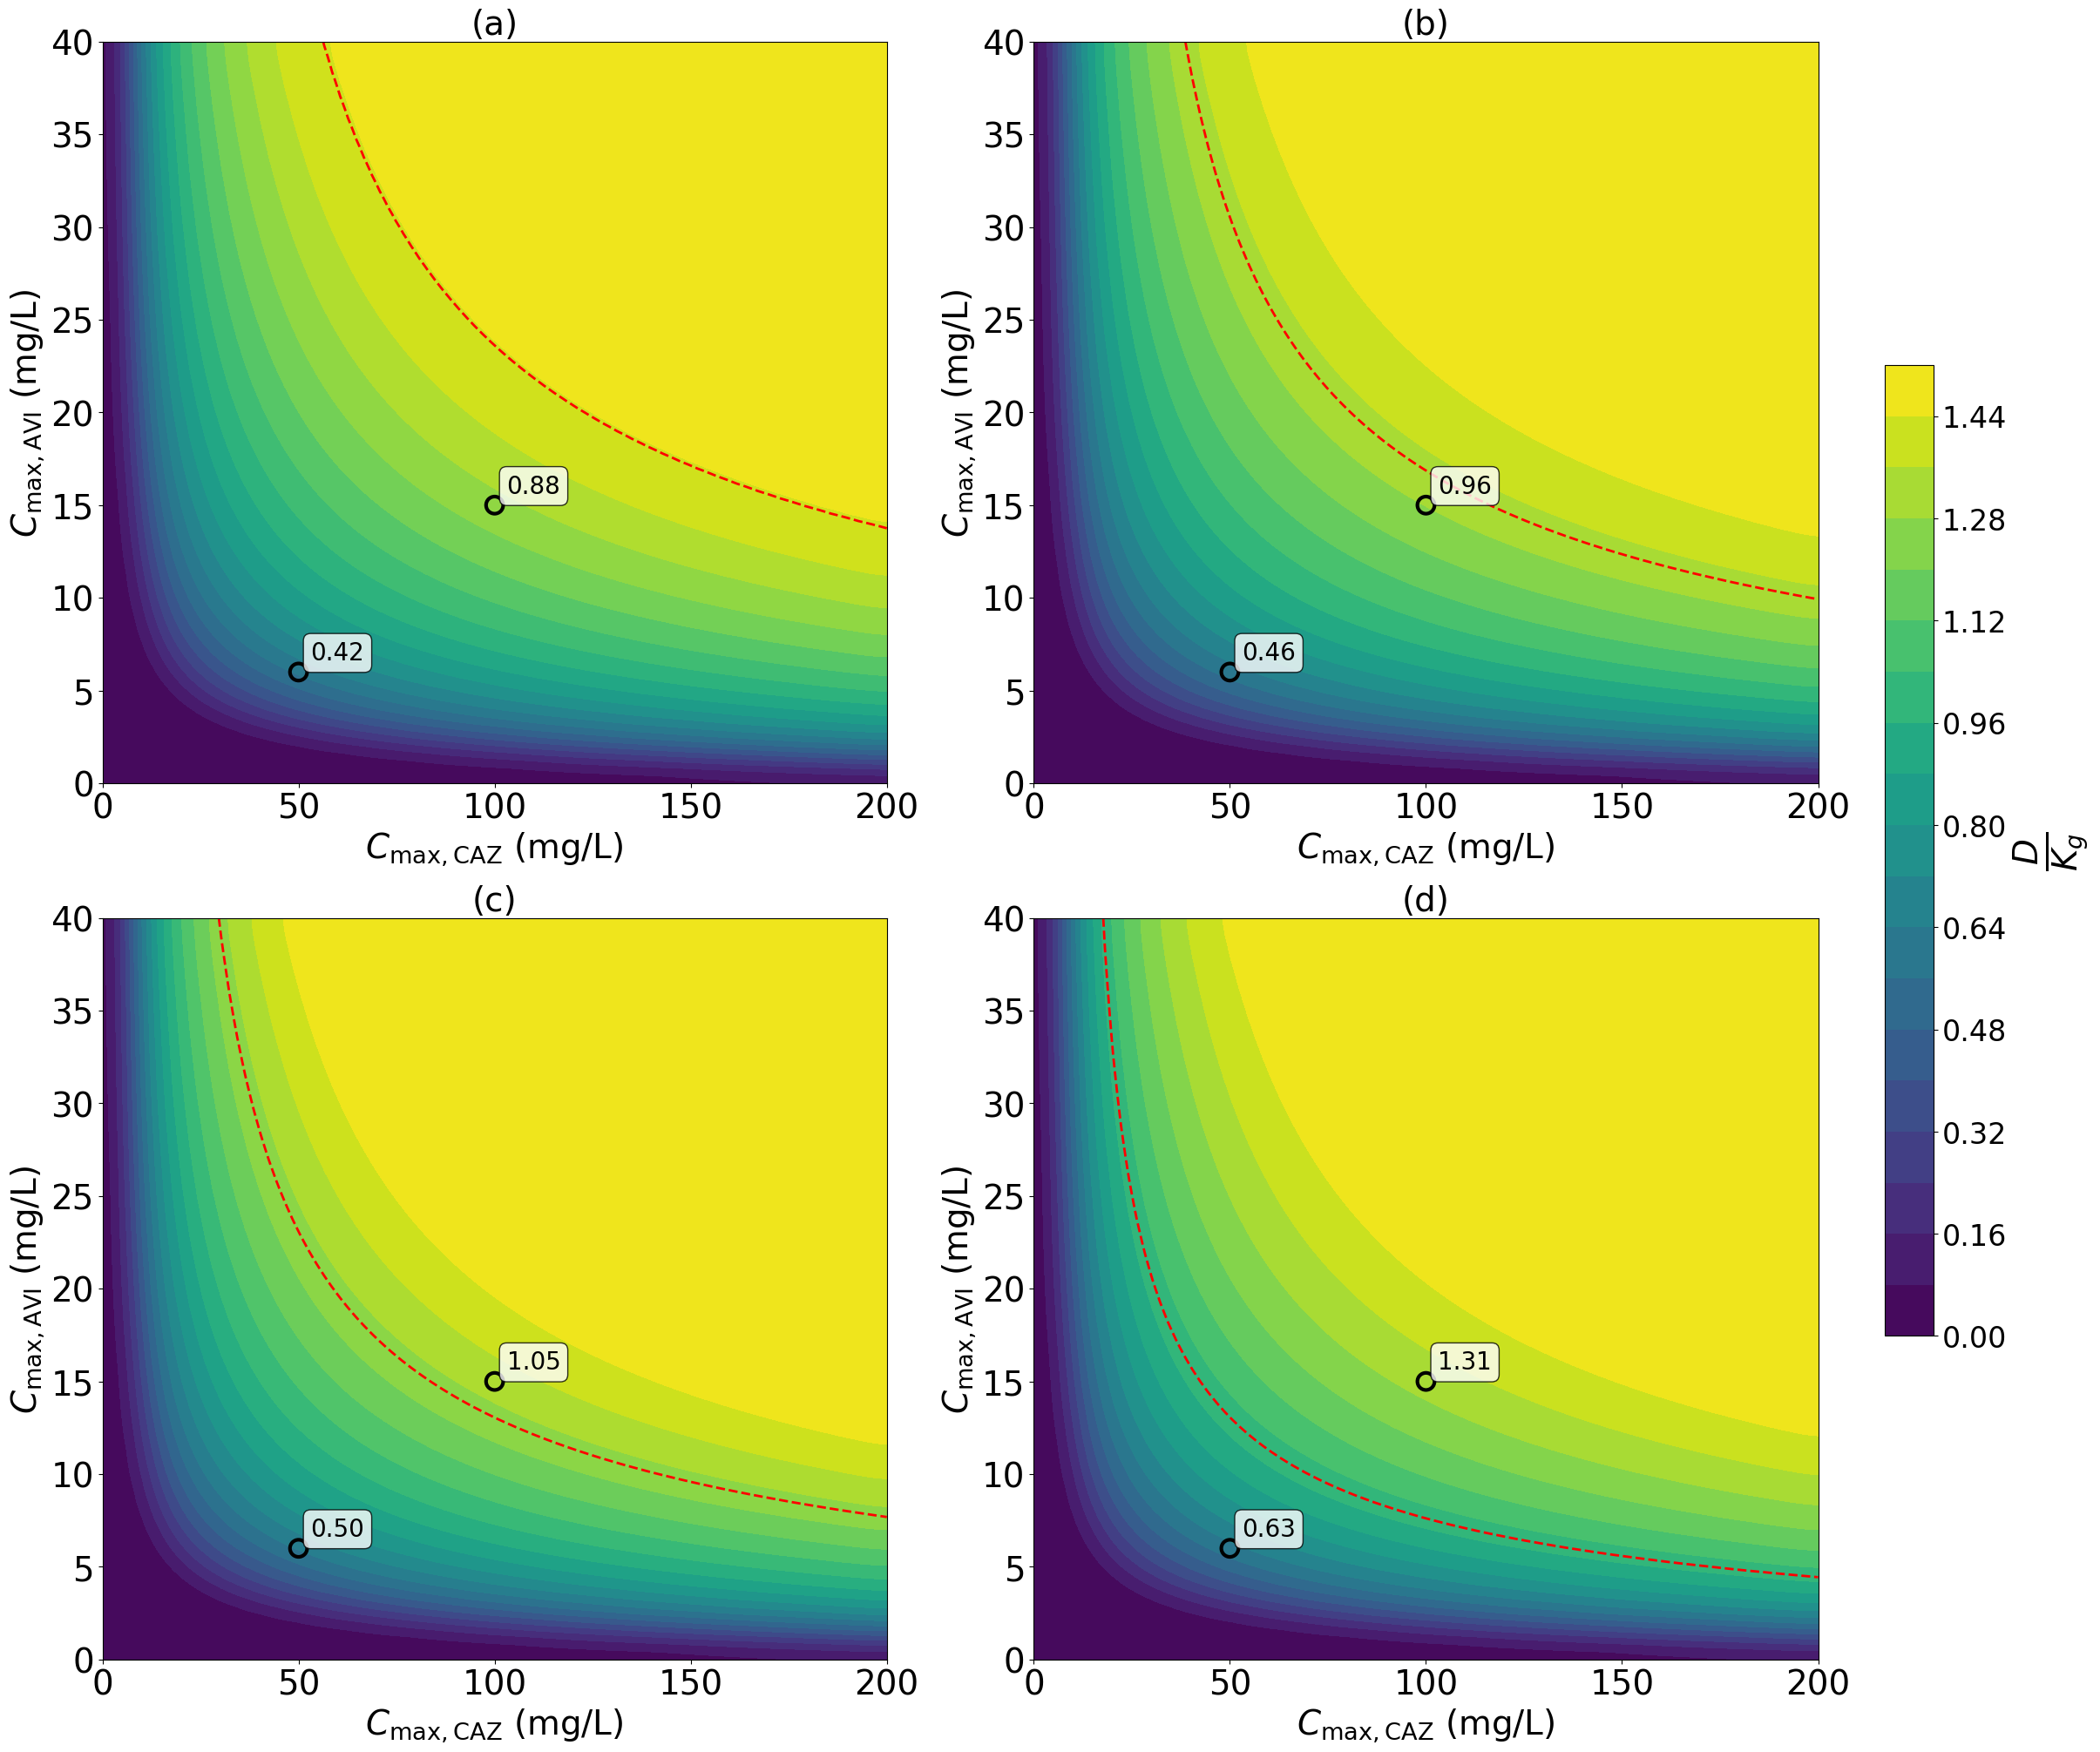

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter

# Constants
H = 12.7
t_half = 2.5
T_dosing = 8.0
a = 0.8458
b = 1.315
c = 0.9073
t_points = 2
D_target = 1.0

# Updated pharmacodynamic function
def C_t(t, Cmax):
    f0 = 2 ** (-(T_dosing - t_points) / t_half)
    if t <= t_points:
        return Cmax * (f0 * (1 - t / t_points) + t / t_points)
    else:
        return Cmax * 2 ** (-(t - t_points) / t_half)

def r_min_piecewise(t, Cmax_CAZ, Cmax_AVI):
    C_CAZ = C_t(t, Cmax_CAZ)
    C_AVI = C_t(t, Cmax_AVI)
    log10_C50 = a / (b - (c ** C_AVI))
    C50 = 10 ** log10_C50
    num = C_CAZ ** H
    den = num + C50 ** H
    return num / den

# Grid
Caz_vals = np.linspace(0, 200, 100)
Avi_vals = np.linspace(0, 40, 100)
X, Y = np.meshgrid(Caz_vals, Avi_vals)

# Dosing points
dosing_pts = [(100, 15), (50, 6)]

# K values and labels
K_values = [1.01, 1.1, 1.2, 1.5]
panel_labels = ['(a)', '(b)', '(c)', '(d)']

# Plot
fig, axes = plt.subplots(2, 2, figsize=(24, 20), constrained_layout=True)

for ax, K, lbl in zip(axes.ravel(), K_values, panel_labels):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            int1, _ = quad(lambda t: r_min_piecewise(t, X[i, j], Y[i, j]), 0, T_dosing)
            avg_rmin = int1 / T_dosing
            Z[i, j] = K * avg_rmin

    Z_smooth = gaussian_filter(Z, sigma=2)
    cf = ax.contourf(X, Y, Z_smooth, levels=20, cmap='viridis')
    ax.contour(X, Y, Z, levels=[D_target], colors='red', linestyles='--', linewidths=2)

    for C_CAZ, C_AVI in dosing_pts:
        ax.scatter(C_CAZ, C_AVI, s=200, facecolors='none', edgecolors='black', linewidths=3)

        # Annotate D/Kg value at this point
        i_caz = np.abs(Caz_vals - C_CAZ).argmin()
        i_avi = np.abs(Avi_vals - C_AVI).argmin()
        D_val = Z[i_avi, i_caz]
        ax.annotate(f"{D_val:.2f}", xy=(C_CAZ, C_AVI), xytext=(10, 10),
                    textcoords='offset points', fontsize=20, color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}$ (mg/L)', fontsize=28)
    ax.set_ylabel(r'$C_{\mathrm{max,AVI}}$ (mg/L)', fontsize=28)
    ax.set_title(lbl, fontsize=28)
    ax.tick_params(axis='both', labelsize=28)

# Colorbar
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label(r'$\frac{D}{K_g}$', fontsize=40)
cbar.ax.tick_params(labelsize=24)

plt.show()


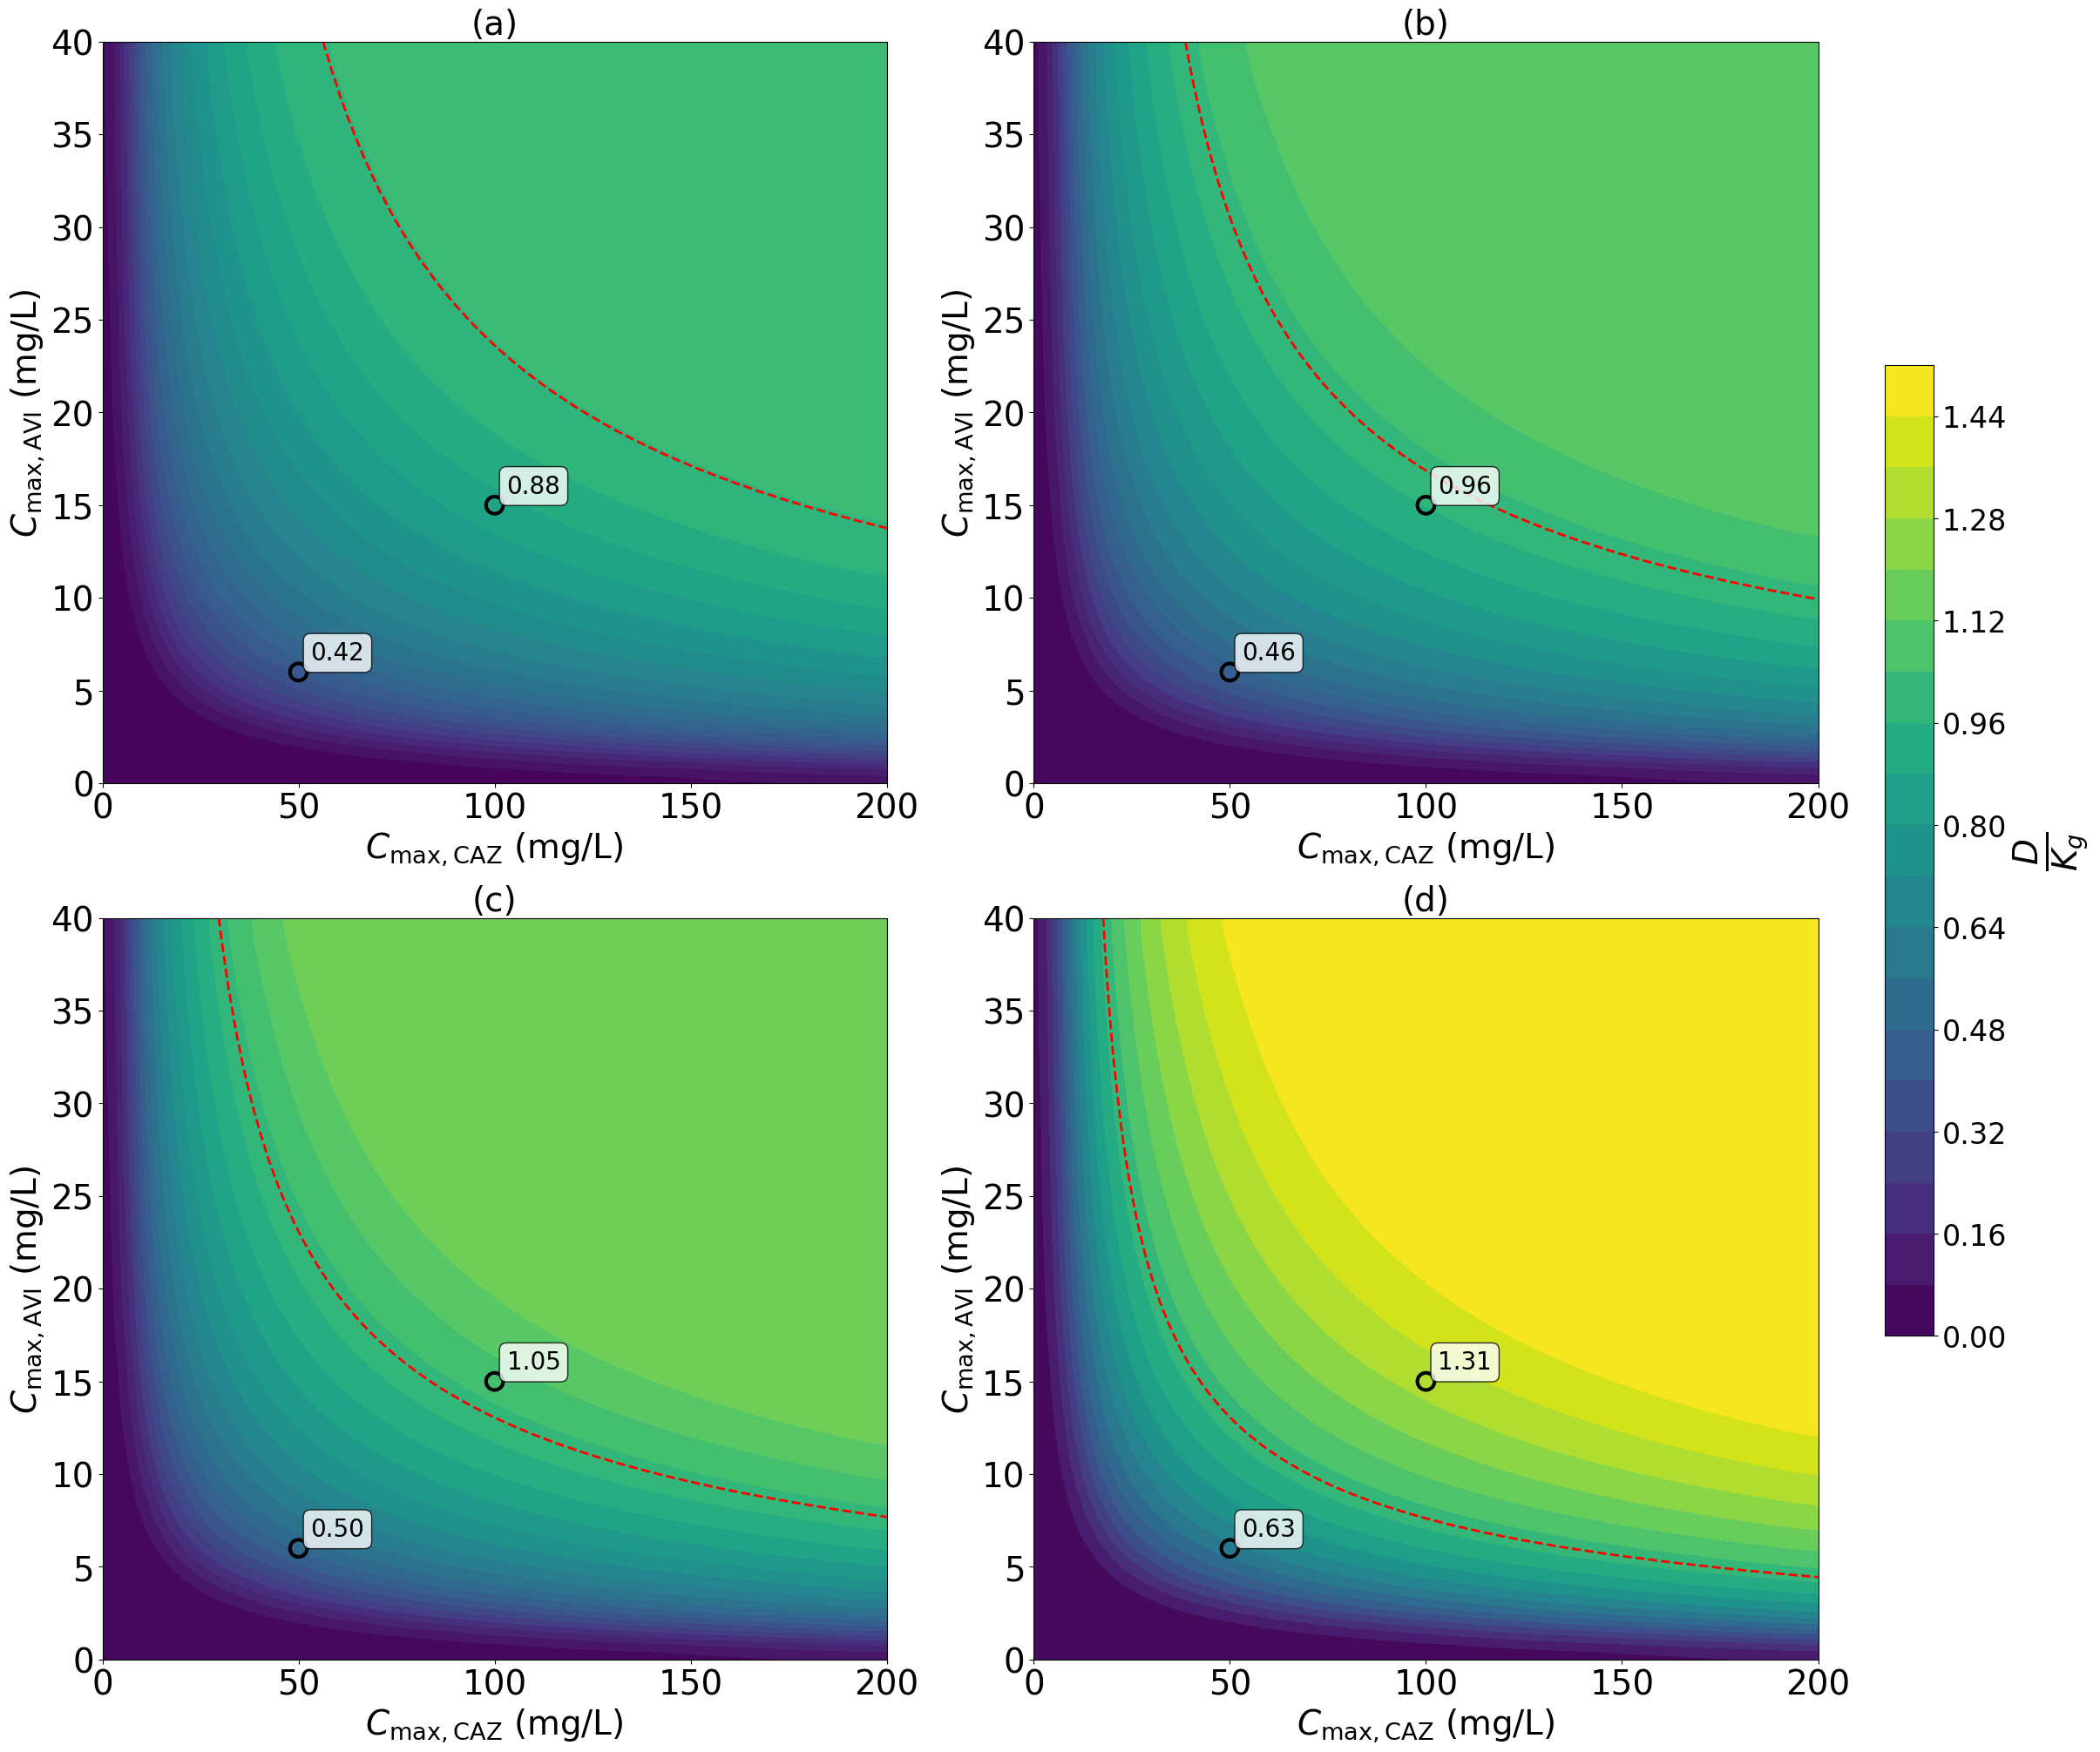

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter

# ─────────────────────────────────────────────────────────────────────────────
# Constants
H        = 12.7
t_half   = 2.5
T_dosing = 8.0
a, b, c  = 0.8458, 1.315, 0.9073
t_points = 2
D_target = 1.0

# PK curve
def C_t(t, Cmax):
    f0 = 2 ** (-(T_dosing - t_points) / t_half)
    return (Cmax * (f0 * (1 - t / t_points) + t / t_points)
            if t <= t_points else
            Cmax * 2 ** (-(t - t_points) / t_half))

def r_min_piecewise(t, Cmax_CAZ, Cmax_AVI):
    C_CAZ = C_t(t, Cmax_CAZ)
    C_AVI = C_t(t, Cmax_AVI)
    log10_C50 = a / (b - c ** C_AVI)
    C50 = 10 ** log10_C50
    return (C_CAZ ** H) / (C_CAZ ** H + C50 ** H)

# ─────────────────────────────────────────────────────────────────────────────
# Grid & constants for plotting
Caz_vals = np.linspace(0, 200, 100)
Avi_vals = np.linspace(0, 40, 100)
X, Y = np.meshgrid(Caz_vals, Avi_vals)

K_values     = [1.01, 1.1, 1.2, 1.5]
panel_labels = ['(a)', '(b)', '(c)', '(d)']
dosing_pts   = [(100, 15), (50, 6)]

# ── 1. Pre‑compute Z for every K to get global colour limits ────────────────
Z_list = []
for K in K_values:
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            integral, _ = quad(lambda t: r_min_piecewise(t, X[i, j], Y[i, j]), 0, T_dosing)
            Z[i, j] = K * (integral / T_dosing)
    Z_list.append(Z)

Z_min = min(z.min() for z in Z_list)
Z_max = max(z.max() for z in Z_list)

# ── 2. Plot with shared vmin / vmax ─────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(24, 20), constrained_layout=True)

for ax, K, lbl, Z in zip(axes.ravel(), K_values, panel_labels, Z_list):
    Z_smooth = gaussian_filter(Z, sigma=2)

    cf = ax.contourf(X, Y, Z_smooth, levels=20, cmap='viridis',
                     vmin=Z_min, vmax=Z_max)         # <‑‑ colour‑scale fixed
    ax.contour(X, Y, Z, levels=[D_target],
               colors='red', linestyles='--', linewidths=2)

    # annotate dosing points
    for C_CAZ, C_AVI in dosing_pts:
        ax.scatter(C_CAZ, C_AVI, s=200, facecolors='none',
                   edgecolors='black', linewidths=3)

        # exact D/K_g at that location (from unsmoothed Z)
        i_caz = np.abs(Caz_vals - C_CAZ).argmin()
        i_avi = np.abs(Avi_vals - C_AVI).argmin()
        D_val = Z[i_avi, i_caz]
        ax.annotate(f"{D_val:.2f}", xy=(C_CAZ, C_AVI), xytext=(10, 10),
                    textcoords='offset points', fontsize=20,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # axis cosmetics
    ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}$ (mg/L)', fontsize=28)
    ax.set_ylabel(r'$C_{\mathrm{max,AVI}}$ (mg/L)', fontsize=28)
    ax.set_title(lbl, fontsize=28)
    ax.tick_params(axis='both', labelsize=28)

# ── 3. Shared colour‑bar ----------------------------------------------------
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label(r'$\frac{D}{K_g}$', fontsize=40)
cbar.ax.tick_params(labelsize=24)

plt.show()


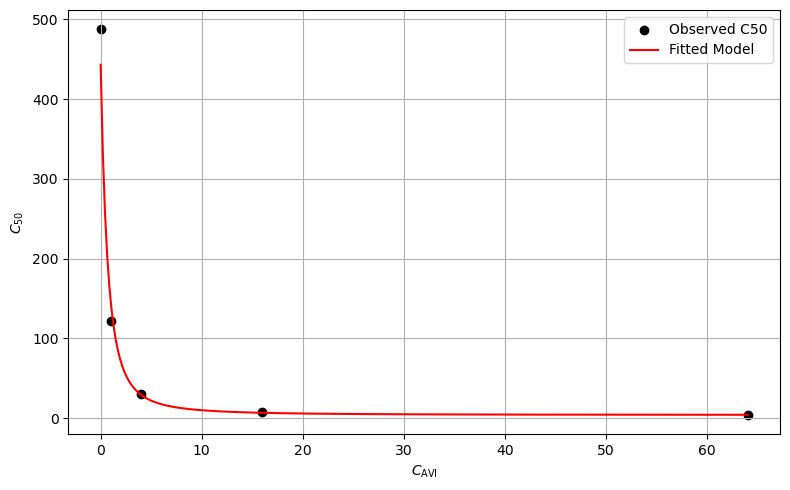


Fitted parameters (rounded):
a = -0.797
b = 0.933
c = -1.301
R² (log10-space) = 0.99553

Verification table:
C_AVI=  0, Obs= 487.500, Pred= 442.995
C_AVI=  1, Obs= 122.000, Pred= 145.677
C_AVI=  4, Obs=  30.475, Pred=  29.145
C_AVI= 16, Obs=   7.620, Pred=   6.596
C_AVI= 64, Obs=   3.808, Pred=   4.150


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

C_AVI = np.array([0, 1, 4, 16, 64])
C50_obs = np.array([487.5, 122, 30.475, 7.62, 3.8075])
log10_C50_obs = np.log10(C50_obs)

def model(C_AVI, a, b, c):
    denom = b**C_AVI + c
    return a / denom

popt, _ = curve_fit(model, C_AVI, log10_C50_obs, p0=[1.0, 1.0, 1.0])
a_fit, b_fit, c_fit = popt

log10_C50_pred = model(C_AVI, a_fit, b_fit, c_fit)
C50_pred = 10 ** log10_C50_pred
r2 = np.corrcoef(log10_C50_obs, log10_C50_pred)[0, 1]**2

C_AVI_fit = np.linspace(0, 64, 300)
log10_C50_fit = model(C_AVI_fit, a_fit, b_fit, c_fit)
C50_fit = 10 ** log10_C50_fit

plt.figure(figsize=(8, 5))
plt.scatter(C_AVI, C50_obs, color='black', label='Observed C50')
plt.plot(C_AVI_fit, C50_fit, 'r-', label='Fitted Model')
plt.xlabel(r'$C_{\mathrm{AVI}}$')
plt.ylabel(r'$C_{50}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nFitted parameters (rounded):")
print(f"a = {a_fit:.3f}")
print(f"b = {b_fit:.3f}")
print(f"c = {c_fit:.3f}")
print(f"R² (log10-space) = {r2:.5f}")

print("\nVerification table:")
for i in range(len(C_AVI)):
    print(f"C_AVI={C_AVI[i]:>3}, Obs={C50_obs[i]:>8.3f}, Pred={C50_pred[i]:>8.3f}")


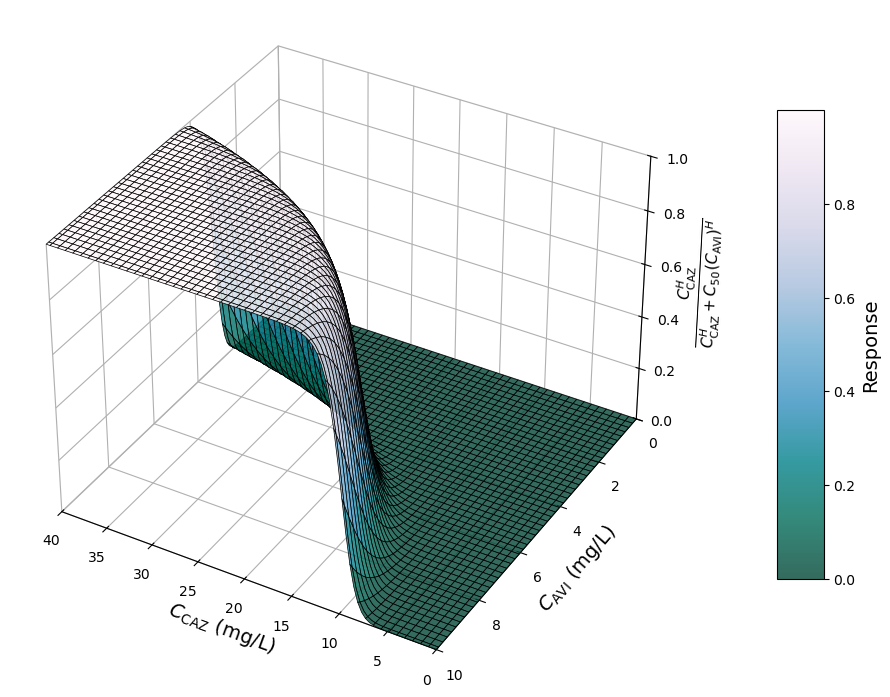

In [22]:
 import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a = -0.797
b = 0.933
c = -1.301
H = 12.8

CAZ = np.linspace(0, 40, 100)
AVI = np.linspace(0, 10, 100)
CAZ_grid, AVI_grid = np.meshgrid(CAZ, AVI)

denom = b**AVI_grid + c
C50_AVI = 10**(a / denom)

numerator = CAZ_grid**H
response = numerator / (numerator + C50_AVI**H)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(CAZ_grid, AVI_grid, response,
                       cmap='PuBuGn_r',
                       edgecolor='black', linewidth=0.5,
                       antialiased=True, alpha=0.8)

# Colorbar
cbar = fig.colorbar(surf, shrink=0.7, aspect=10, pad=0.1)
cbar.set_label(r'Response', fontsize=14)

# Transparent walls
ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel(r'$C_{\mathrm{CAZ}}\ (\mathrm{mg/L})$', fontsize=14)
ax.set_ylabel(r'$C_{\mathrm{AVI}}\ (\mathrm{mg/L})$', fontsize=14)
ax.set_zlabel(r'$\frac{C_{\mathrm{CAZ}}^H}{C_{\mathrm{CAZ}}^H + C_{50}(C_{\mathrm{AVI}})^H}$', fontsize=16)
ax.view_init(elev=35, azim=120)
ax.set_xlim(0, 40)
ax.set_ylim(0, 10)
ax.set_zlim(0, 1)

plt.tight_layout()
plt.show()


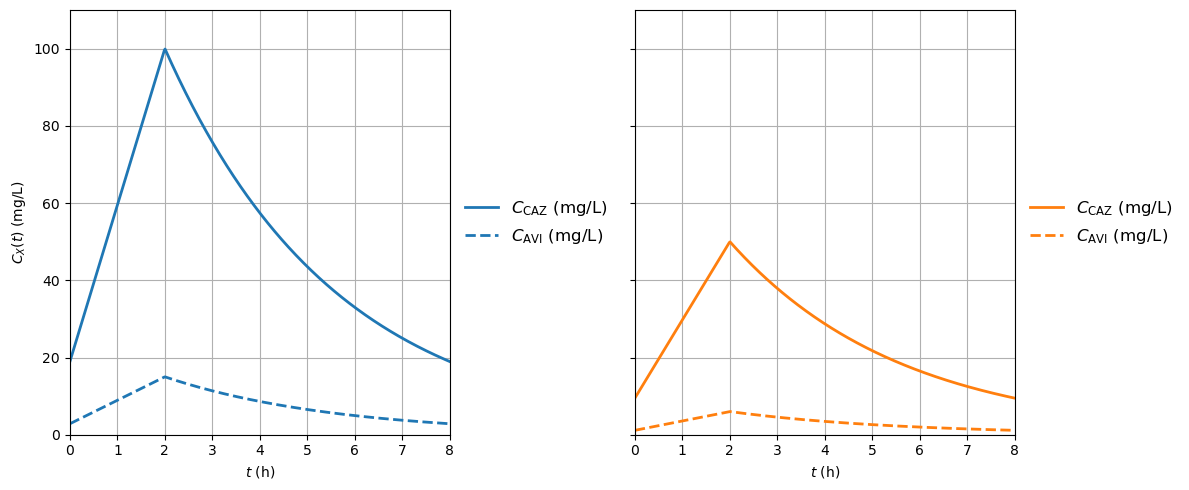

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def C_t(Cmax, T0, Tperiod, t_half, t):
    kel = np.log(2) / t_half
    A = 2 ** (-(Tperiod - T0) / t_half)
    C = np.zeros_like(t)
    mask = t <= T0
    C[mask] = Cmax * (A * (1 - t[mask]/T0) + t[mask]/T0)
    C[~mask] = Cmax * 2 ** (-(t[~mask] - T0) / t_half)
    return C

T0 = 2
Tperiod = 8
t_half = 2.5
t = np.linspace(0, Tperiod, 500)

scenarios = [
    dict(Cmax_CAZ=100, Cmax_AVI=15, color="#1f77b4"),
    dict(Cmax_CAZ=50,  Cmax_AVI=6,  color="#ff7f0e")
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, sc in enumerate(scenarios):
    C_CAZ = C_t(sc["Cmax_CAZ"], T0, Tperiod, t_half, t)
    C_AVI = C_t(sc["Cmax_AVI"], T0, Tperiod, t_half, t)
    ax = axes[i]
    ax.plot(t, C_CAZ, color=sc["color"], linewidth=2, label=r"$C_{\mathrm{CAZ}}\ (\mathrm{mg/L})$")
    ax.plot(t, C_AVI, color=sc["color"], linewidth=2, linestyle='--', label=r"$C_{\mathrm{AVI}}\ (\mathrm{mg/L})$")
    ax.set_xlabel(r"$t\ (\mathrm{h})$")
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 110)
    ax.grid(True)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12)

axes[0].set_ylabel(r"$C_X(t)\ (\mathrm{mg/L})$")
plt.tight_layout()
plt.show()


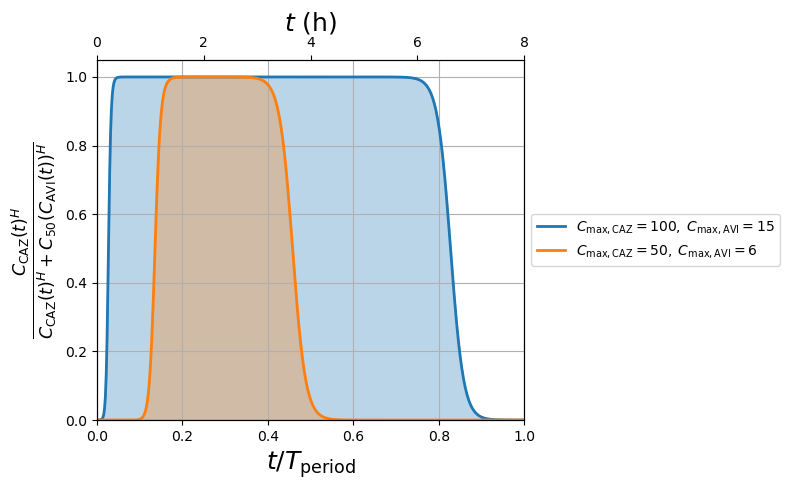

In [28]:
import numpy as np
import matplotlib.pyplot as plt

H = 12.8
a, b, c = -0.797, 0.933, -1.301

T_period = 8
t = np.linspace(0, T_period, 500)
t_norm = t / T_period

def C_t(Cmax, T0, Tperiod, t_half, t):
    kel  = np.log(2) / t_half
    A    = 2 ** (-(Tperiod - T0)/t_half)
    C    = np.zeros_like(t)
    mask = t <= T0
    C[mask]  = Cmax * (A * (1 - t[mask]/T0) + t[mask]/T0)
    C[~mask] = Cmax * 2 ** (-(t[~mask] - T0)/t_half)
    return C

scenarios = [
    dict(Cmax_CAZ=100, Cmax_AVI=15, color='#1f77b4',
         label=r'$C_{\max,\mathrm{CAZ}}=100,\;C_{\max,\mathrm{AVI}}=15$'),
    dict(Cmax_CAZ=50,  Cmax_AVI=6,  color='#ff7f0e',
         label=r'$C_{\max,\mathrm{CAZ}}=50,\;C_{\max,\mathrm{AVI}}=6$')
]

fig, ax = plt.subplots(figsize=(8, 5))

for sc in scenarios:
    C_CAZ = C_t(sc["Cmax_CAZ"], T0=2, Tperiod=8, t_half=2.5, t=t)
    C_AVI = C_t(sc["Cmax_AVI"], T0=2, Tperiod=8, t_half=2.5, t=t)
    denom = b**C_AVI + c
    C50 = 10**(a / denom)
    num = C_CAZ**H
    E = num / (num + C50**H)
    ax.fill_between(t_norm, 0, E, color=sc["color"], alpha=0.3)
    ax.plot(t_norm, E, color=sc["color"], lw=2, label=sc["label"])

ax.set_xlabel(r'$t/T_{\mathrm{period}}$',fontsize=18)
ax.set_ylabel(r'$\frac{C_{\mathrm{CAZ}}(t)^H}{C_{\mathrm{CAZ}}(t)^H + C_{50}(C_{\mathrm{AVI}}(t))^H}$', fontsize=18)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.grid(True)

ax_top = ax.twiny()
ax_top.set_xlim(0, 1)
ax_top.set_xticks(np.linspace(0, 1, 5))
ax_top.set_xticklabels(['0', '2', '4', '6', '8'])
ax_top.set_xlabel(r'$t$ (h)',fontsize=18)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()



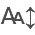

In [44]:
import numpy as np
from scipy.integrate import quad
import pandas as pd
from itables import show, init_notebook_mode

init_notebook_mode(all_interactive=True)

H = 12.8
t_half = 2.5
T_period = 8.0
T0 = 2.0
a, b, c = -0.797, 0.933, -1.301

def conc_profile(t, C_max):
    if t <= T0:
        factor0 = 2 ** (-(T_period - T0) / t_half)
        return C_max * (factor0 * (1 - t / T0) + t / T0)
    return C_max * 2 ** (-(t - T0) / t_half)

def r_min(t, C_max_CAZ, C_max_AVI):
    C_CAZ_t = conc_profile(t, C_max_CAZ)
    C_AVI_t = conc_profile(t, C_max_AVI)
    log10_C50 = a / (b ** C_AVI_t + c)
    C50 = 10 ** log10_C50
    num = C_CAZ_t ** H
    return num / (num + C50 ** H)

combinations = [(100, 15), (50, 6)]
K_vals = [1.01, 1.1, 1.2, 1.5]

rows = []
for K in K_vals:
    for C_CAZ, C_AVI in combinations:
        integral, _ = quad(lambda t: r_min(t, C_CAZ, C_AVI), 0, T_period, limit=100)
        avg_rmin = integral / T_period
        rows.append({
            "Kmax/Kg": K,
            "Cmax CAZ (mg/L)": C_CAZ,
            "Cmax AVI (mg/L)": C_AVI,
            "Avg r_min (h⁻¹)": round(avg_rmin, 4),
            "D/Kg": round(K * avg_rmin, 4)
        })

df = pd.DataFrame(rows)
show(df)


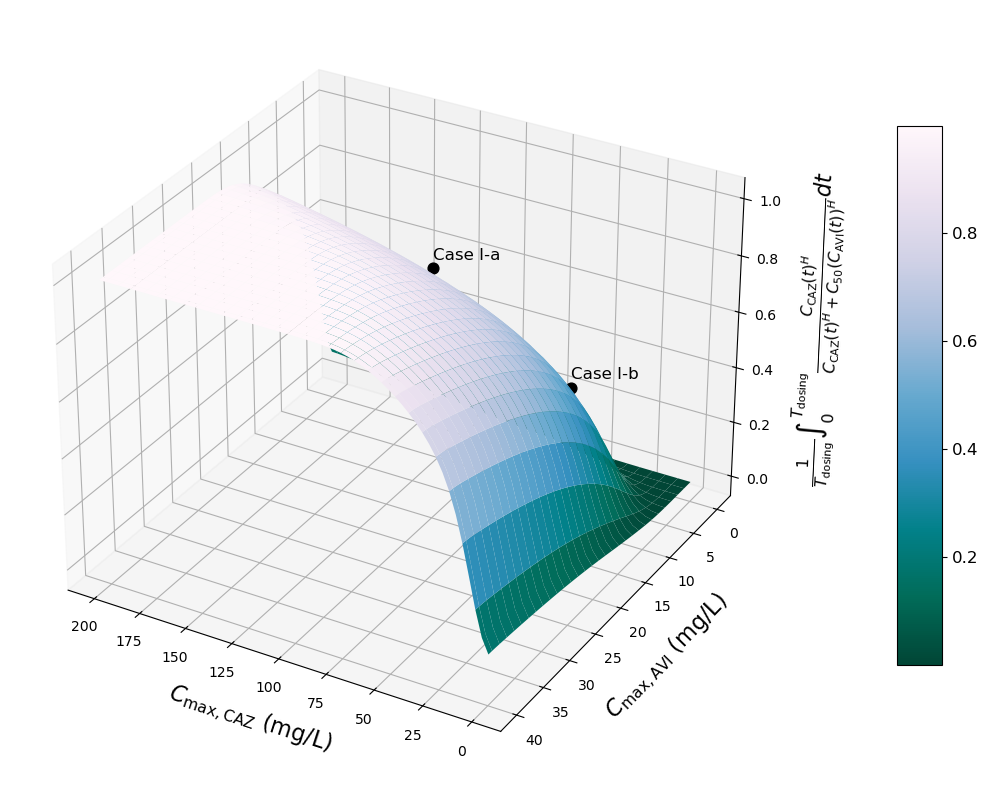

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
from matplotlib.colors import LightSource, Normalize
from matplotlib.cm import ScalarMappable

H = 12.8
t_half = 2.5
T_period = 8.0
T0 = 2.0
a, b, c = -0.797, 0.933, -1.301

def C_t(t, C_max):
    f0 = 2 ** (-(T_period - T0) / t_half)
    if t <= T0:
        return C_max * (f0 * (1 - t / T0) + t / T0)
    else:
        return C_max * 2 ** (-(t - T0) / t_half)

def r_min(t, C_max_CAZ, C_max_AVI):
    C_CAZ_t = C_t(t, C_max_CAZ)
    C_AVI_t = C_t(t, C_max_AVI)
    log10_C50 = a / (b ** C_AVI_t + c)
    C50 = 10 ** log10_C50
    num = C_CAZ_t ** H
    return num / (num + C50 ** H)

CAZ_vals = np.linspace(0, 200, 60)
AVI_vals = np.linspace(0, 40, 60)
X, Y = np.meshgrid(CAZ_vals, AVI_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        integral, _ = quad(lambda t: r_min(t, X[i, j], Y[i, j]), 0, T_period, limit=100)
        Z[i, j] = integral / T_period

Z_smooth = gaussian_filter(Z, sigma=2.0)

Cmax_CAZ_a, Cmax_AVI_a = 100, 15
integral_a, _ = quad(lambda t: r_min(t, Cmax_CAZ_a, Cmax_AVI_a), 0, T_period, limit=100)
Z_a = integral_a / T_period

Cmax_CAZ_b, Cmax_AVI_b = 50, 6
integral_b, _ = quad(lambda t: r_min(t, Cmax_CAZ_b, Cmax_AVI_b), 0, T_period, limit=100)
Z_b = integral_b / T_period

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

norm = Normalize(vmin=np.min(Z_smooth), vmax=np.max(Z_smooth))
cmap = plt.colormaps.get_cmap('PuBuGn_r')
surf = ax.plot_surface(X, Y, Z_smooth, cmap=cmap, norm=norm, edgecolor='none', linewidth=0, antialiased=True, alpha=1)

ax.scatter(Cmax_CAZ_a, Cmax_AVI_a, Z_a+0.03, color='k', s=60, zorder=10)
ax.text(Cmax_CAZ_a, Cmax_AVI_a, Z_a+0.06, "Case I-a", fontsize=12, color='k')
ax.scatter(Cmax_CAZ_b, Cmax_AVI_b, Z_b+0.03, color='k', s=60, zorder=10)
ax.text(Cmax_CAZ_b, Cmax_AVI_b, Z_b+0.06, "Case I-b", fontsize=12, color='k')

ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}$ (mg/L)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$C_{\mathrm{max,AVI}}$ (mg/L)', fontsize=16, labelpad=10)
ax.set_zlabel(r'$\frac{1}{T_{\mathrm{dosing}}} \int_0^{T_{\mathrm{dosing}}} \frac{C_{\mathrm{CAZ}}(t)^H}{C_{\mathrm{CAZ}}(t)^H + C_{50}(C_{\mathrm{AVI}}(t))^H} dt$', fontsize=16, labelpad=15)

mappable = ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax, shrink=0.7, aspect=12, pad=0.1)
cbar.ax.tick_params(labelsize=12)

ax.view_init(elev=30, azim=120)
plt.tight_layout()
plt.show()


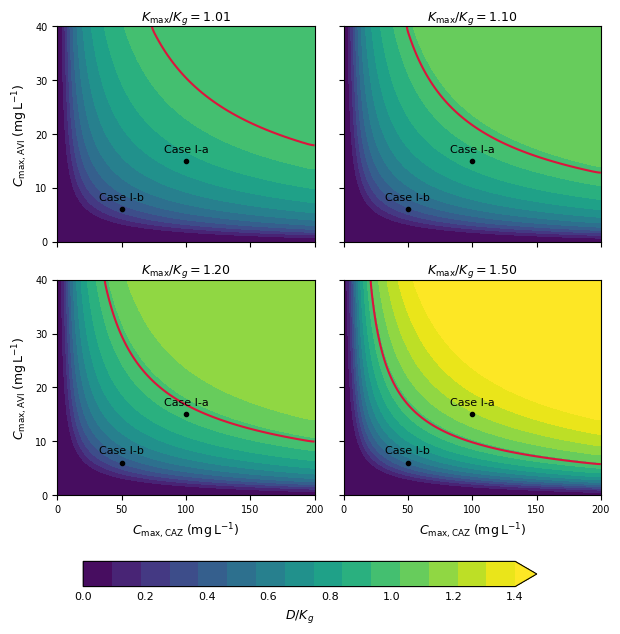

In [152]:
import warnings, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter

warnings.filterwarnings("ignore", category=UserWarning)

H, t_half, T_period, T0 = 12.8, 2.5, 8.0, 2.0
a, b, c = -0.797, 0.933, -1.301

def C_t(t, Cmax):
    f0 = 2**(-(T_period - T0) / t_half)
    return Cmax * (f0*(1 - t/T0) + t/T0) if t <= T0 else Cmax * 2**(-(t-T0)/t_half)

def r_min(t, ccaz, cavi):
    num = C_t(t, ccaz) ** H
    C50 = 10 ** (a / (b ** C_t(t, cavi) + c))
    return num / (num + C50 ** H)

x = np.linspace(0, 200, 120)
y = np.linspace(0,  40, 120)
X, Y = np.meshgrid(x, y)
base = np.zeros_like(X)
for i in range(len(y)):
    for j in range(len(x)):
        base[i, j] = quad(r_min, 0, T_period, args=(X[i, j], Y[i, j]))[0] / T_period
base = gaussian_filter(base, 2.0)

pts  = {"Case I-a": (100, 15), "Case I-b": (50, 6)}
zpts = {k: quad(r_min, 0, T_period, args=v)[0] / T_period for k, v in pts.items()}

Kvals  = [1.01, 1.10, 1.20, 1.50]
titles = [fr"$K_{{\max}}/K_g={k:.2f}$" for k in Kvals]
levels = np.linspace(0, 1.4, 16)

fig, axes = plt.subplots(2, 2, figsize=(6.3, 6.3), sharex=True, sharey=True)
axes = axes.ravel()

for ax, k, ttl in zip(axes, Kvals, titles):
    Z = k * base
    ctf = ax.contourf(X, Y, Z, levels=levels, cmap="viridis", extend="max")
    ax.contour(X, Y, Z, levels=[1.0], colors="crimson", linewidths=1.5)
    for lab, (xc, yc) in pts.items():
        ax.plot(xc, yc, "k.", ms=6)
        ax.text(xc, yc + 1.3, lab, ha="center", va="bottom", fontsize=8)
    ax.set_title(ttl, fontsize=9, pad=4)
    ax.set_xlim(0, 200); ax.set_ylim(0, 40)
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yticks([0, 10, 20, 30, 40])
    ax.tick_params(labelsize=7)

for a in axes[::2]:
    a.set_ylabel(r"$C_{\max,\mathrm{AVI}}\;(\mathrm{mg\,L^{-1}})$", fontsize=9)
for a in axes[-2:]:
    a.set_xlabel(r"$C_{\max,\mathrm{CAZ}}\;(\mathrm{mg\,L^{-1}})$", fontsize=9)

cax = fig.add_axes([0.14, 0.06, 0.72, 0.04])
cbar = fig.colorbar(ctf, cax=cax, orientation="horizontal", ticks=np.arange(0, 1.5, 0.2))
cbar.ax.tick_params(labelsize=8, length=0)
cbar.set_label(r"$D/K_g$", fontsize=9)   
fig.tight_layout(rect=[0, 0.11, 1, 1])
plt.show()


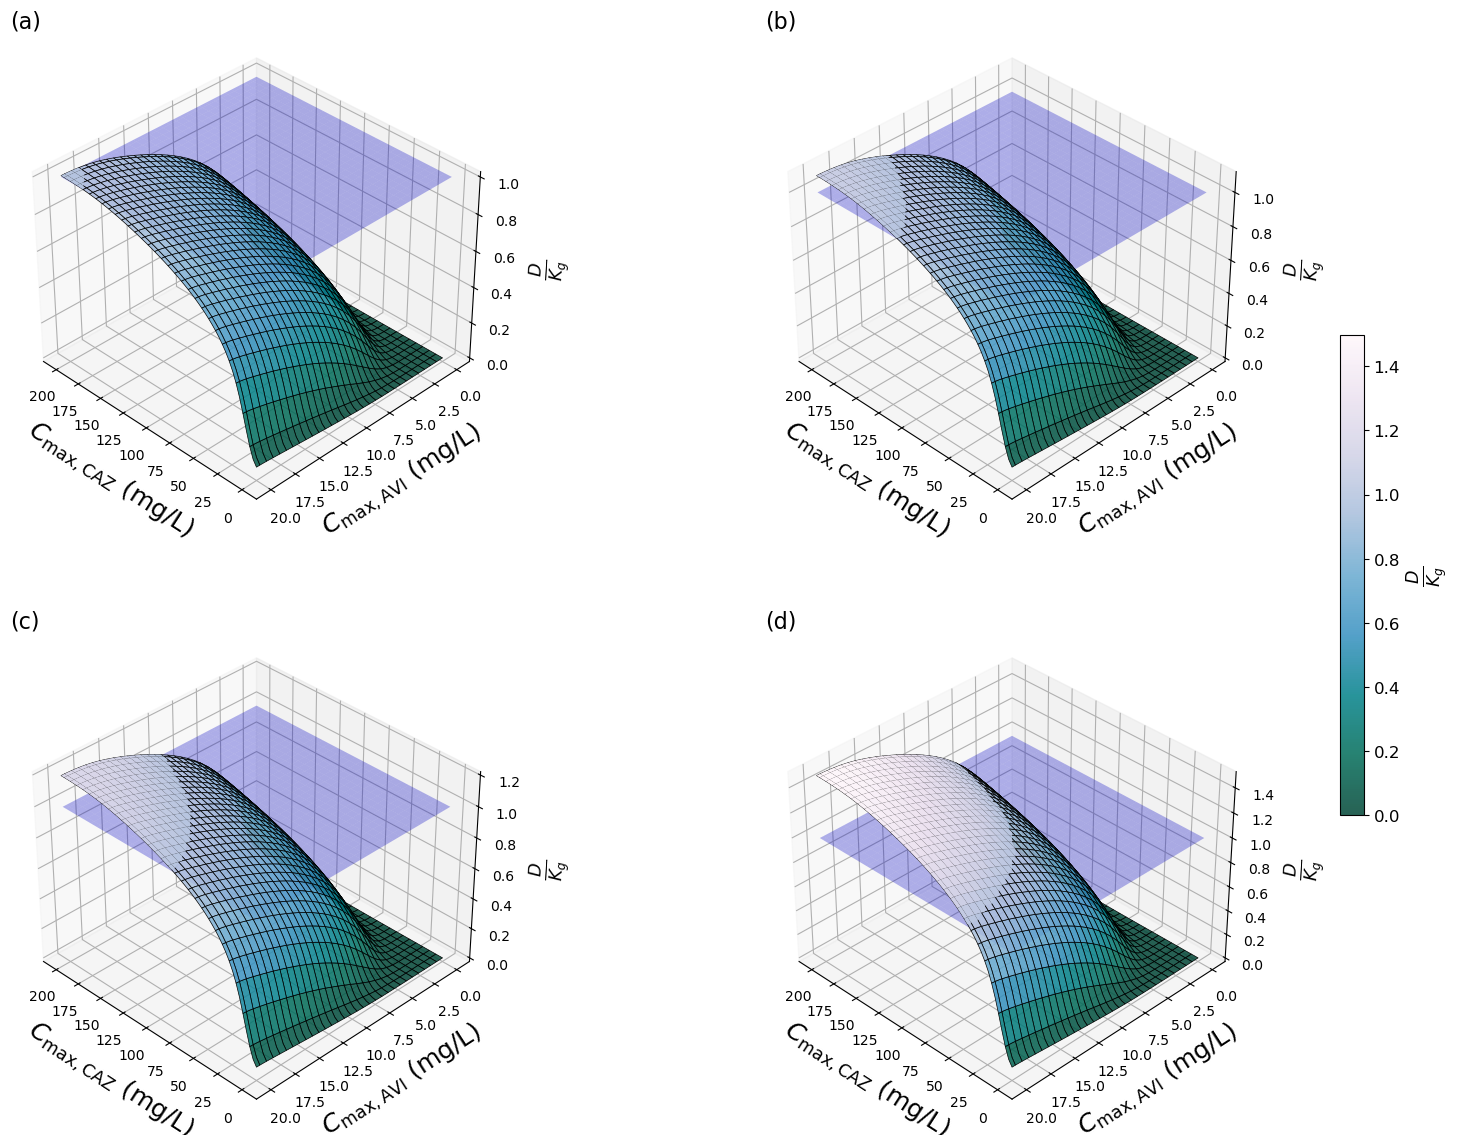

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

H = 12.8
t_half = 2.5
T_dosing = 8.0
T0 = 2.0
a, b, c = -0.797, 0.933, -1.301
D_target = 1.0
K_values = [1.01, 1.10, 1.20, 1.50]
panel_labels = ['(a)', '(b)', '(c)', '(d)']

def C_t(t, Cmax):
    f0 = 2 ** (-(T_dosing - T0) / t_half)
    if t <= T0:
        return Cmax * (f0 * (1 - t / T0) + t / T0)
    else:
        return Cmax * 2 ** (-(t - T0) / t_half)

def r_min_piecewise(t, Cmax_CAZ, Cmax_AVI):
    C_CAZ_t = C_t(t, Cmax_CAZ)
    C_AVI_t = C_t(t, Cmax_AVI)
    denom = b ** C_AVI_t + c
    log10_C50 = a / denom
    C50 = 10 ** log10_C50
    num = C_CAZ_t ** H
    den = num + C50 ** H
    return num / den

Cmax_CAZ_vals = np.linspace(0, 200, 60)
Cmax_AVI_vals = np.linspace(0, 20, 60)
X, Y = np.meshgrid(Cmax_CAZ_vals, Cmax_AVI_vals)

Z_panels = []
vmin_global = np.inf
vmax_global = -np.inf

for K in K_values:
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            integral, _ = quad(lambda t: r_min_piecewise(t, X[i, j], Y[i, j]), 0, T_dosing, limit=100)
            Z[i, j] = K * integral / T_dosing
    Z_smoothed = gaussian_filter(Z, sigma=2)
    Z_panels.append(Z_smoothed)
    vmin_global = min(vmin_global, np.nanmin(Z_smoothed))
    vmax_global = max(vmax_global, np.nanmax(Z_smoothed))

fig = plt.figure(figsize=(16, 12))
surf_list = []

for idx, Z_smoothed in enumerate(Z_panels):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d")
    ax.computed_zorder = False

    surf = ax.plot_surface(X, Y, Z_smoothed, cmap='PuBuGn_r', edgecolor='k',
                            linewidth=0.5, antialiased=True, alpha=0.85,
                            vmin=vmin_global, vmax=vmax_global)
    surf_list.append(surf)

    ax.plot_surface(X, Y, np.full_like(Z_smoothed, D_target),
                    color='blue', alpha=0.3, zorder=0)

    highlight = np.where(Z_smoothed >= D_target, Z_smoothed, np.nan)
    ax.plot_surface(X, Y, highlight, cmap='PuBuGn_r', edgecolor='none',
                    alpha=0.95, vmin=vmin_global, vmax=vmax_global)

    ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}\ (\mathrm{mg/L})$', fontsize=18, labelpad=8)
    ax.set_ylabel(r'$C_{\mathrm{max,AVI}}\ (\mathrm{mg/L})$', fontsize=18, labelpad=8)
    ax.set_zlabel(r'$\frac{D}{K_g}$', fontsize=18, labelpad=10)
    ax.set_title(panel_labels[idx], fontsize=16, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='z', labelsize=10)
    ax.view_init(elev=35, azim=135)

cax = fig.add_axes([0.92, 0.30, 0.015, 0.40])
cbar = fig.colorbar(surf_list[0], cax=cax)
cbar.set_label(r'$\frac{D}{K_g}$', fontsize=18)
cbar.ax.tick_params(labelsize=12)

plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.25, hspace=0.25)
plt.show()
